In [1]:
# ===================================================================
# # 1. Setup & Imports
# This section handles the initial environment setup. It installs all
# required packages silently and creates the necessary project folders.
# ===================================================================
import subprocess
import sys
import os
import glob

print("--- Setting up environment ---")

# Silently install required packages if they are not already present
required_packages = [
    "torch", "torchvision", "timm", "opencv-python", "numpy", "scipy",
    "scikit-learn", "matplotlib", "Pillow", "tqdm", "scikit-image",
    "distinctipy"
]
for pkg in required_packages:
    try:
        __import__(pkg.split('-')[0])
    except ImportError:
        subprocess.run([sys.executable, "-m", "pip", "install", pkg], capture_output=True, check=True)

# Create standard folders for project output
project_folders = ["results", "models", "data", "logs"]
for folder in project_folders:
    os.makedirs(folder, exist_ok=True)

# Import all necessary libraries for the pipeline
import torch
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import KMeans
from scipy.sparse.linalg import eigsh
from scipy import ndimage
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.morphology import remove_small_objects
from torchvision import transforms
import distinctipy

print("--- Environment is ready ---\n")


--- Setting up environment ---
--- Environment is ready ---



In [2]:

# ===================================================================
# # 2. Globals & Configuration
# This section defines all key variables, paths, and settings that
# are used throughout the script for easy modification.
# ===================================================================
# --- Device and Seed Configuration ---
# Set the computation device (GPU if available) and random seeds for reproducibility
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(42)
torch.manual_seed(42)

# --- File Paths ---
DATASET_FOLDER = "silk_dataset"

# --- Images for Evaluation ---
# The specific list of images to be tested, as requested
TEST_IMAGE_FILENAMES = ["img_2711.jpg", "img_2849.jpg", "img_2868.jpg", "img_3009.jpg"]

print(f"Using device: {DEVICE}")
print(f"Dataset folder set to: '{DATASET_FOLDER}'")
print(f"Images to be tested: {TEST_IMAGE_FILENAMES}\n")



Using device: cuda
Dataset folder set to: 'silk_dataset'
Images to be tested: ['img_2711.jpg', 'img_2849.jpg', 'img_2868.jpg', 'img_3009.jpg']



In [3]:
# ===================================================================
# # 3. Data Loading
# Contains helper functions for finding and loading image data.
# ===================================================================
def find_all_images(dataset_folder):
    """
    Scans a directory for all files with common image extensions.
    """
    exts = [".jpg", ".jpeg", ".png", ".bmp", ".tiff"]
    image_paths = []
    for ext in exts:
        image_paths.extend(glob.glob(os.path.join(dataset_folder, f"*{ext}")))
        image_paths.extend(glob.glob(os.path.join(dataset_folder, f"*{ext.upper()}")))
    return sorted(list(set(image_paths)))

# For reference, find all images in the dataset folder
all_image_paths = find_all_images(DATASET_FOLDER)
print(f"Found {len(all_image_paths)} total images in '{DATASET_FOLDER}'.\n")


Found 1351 total images in 'silk_dataset'.



In [4]:

# ===================================================================
# # 4. Models and Logic
# This section contains the core classes for the segmentation pipeline.
# It introduces a more robust, fully automatic labeling system.
# ===================================================================

class DINOFeatureExtractor:
    """
    A wrapper for the DINOv2 model to extract high-level visual features
    from an image. These features are the foundation for the segmentation tasks.
    """
    def __init__(self, model_name='dinov2_vitb14', device='cuda'):
        self.device = device
        print("Initializing DINOv2 model. This may take a moment...")
        self.model = torch.hub.load('facebookresearch/dinov2', model_name, pretrained=True, verbose=False).to(device).eval()
        self.transform = transforms.Compose([
            transforms.Resize((518, 518), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        print("DINOv2 Feature Extractor is ready.\n")

    def extract_features(self, image_path):
        """Processes an image and returns its patch features."""
        image = Image.open(image_path).convert('RGB')
        tensor = self.transform(image).unsqueeze(0).to(self.device)
        with torch.no_grad():
            features = self.model.forward_features(tensor)['x_norm_patchtokens']
            patches = features.reshape(1, 37, 37, -1)
        return patches.squeeze(0).cpu().numpy()

class SemanticSegmentation:
    """
    Performs semantic segmentation and uses a robust heuristic based on
    color properties (hue and saturation) to automatically label the categories.
    """
    def __init__(self, tau=0.12, n_classes=3):
        self.tau = tau
        self.n_classes = n_classes
        self.eps = 1e-8

    def _compute_affinity(self, features):
        """Calculates a similarity matrix between all feature patches."""
        H, W, D = features.shape
        X = features.reshape(-1, D)
        X_norm = X / (np.linalg.norm(X, axis=1, keepdims=True) + self.eps)
        aff = np.maximum(X_norm @ X_norm.T - self.tau, 0)
        return aff

    def _spectral_clustering(self, aff, target_shape):
        """Groups features into clusters based on the affinity matrix."""
        degree = np.sum(aff, axis=1)
        D_inv_sqrt = np.diag(1.0 / (np.sqrt(degree) + self.eps))
        norm_aff = D_inv_sqrt @ aff @ D_inv_sqrt
        
        _, eigvecs = eigsh(norm_aff, k=self.n_classes, which='LM')
        
        H_feat, W_feat = int(np.sqrt(len(aff))), int(np.sqrt(len(aff)))
        eigvecs_reshaped = eigvecs.reshape(H_feat, W_feat, self.n_classes)
        eigvecs_resized = cv2.resize(eigvecs_reshaped, (target_shape[1], target_shape[0]), cv2.INTER_LINEAR)
        
        kmeans = KMeans(n_clusters=self.n_classes, random_state=42, n_init='auto')
        labels = kmeans.fit_predict(eigvecs_resized.reshape(-1, self.n_classes))
        return labels.reshape(target_shape)

    def _label_categories(self, label_map, original_image):
        """A robust, fully automatic labeling heuristic based on color properties."""
        hsv_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2HSV)
        cluster_props = {}
        for i in range(self.n_classes):
            mask = (label_map == i)
            if not np.any(mask): continue
            cluster_props[i] = {
                'sat': np.mean(hsv_image[:,:,1][mask]),  # Saturation
                'hue': np.mean(hsv_image[:,:,0][mask])   # Hue
            }

        if len(cluster_props) < 3: return {k: f"unknown_{k}" for k in cluster_props}

        label_to_name = {}
        remaining_labels = list(cluster_props.keys())

        # Heuristic 1: Silkworms have the lowest color saturation (most white/gray).
        silkworm_label = min(remaining_labels, key=lambda k: cluster_props[k]['sat'])
        label_to_name[silkworm_label] = 'silkworms'
        remaining_labels.remove(silkworm_label)

        # Heuristic 2: Leaves have a hue closest to green (60 on a 0-180 scale).
        leaf_label = min(remaining_labels, key=lambda k: abs(cluster_props[k]['hue'] - 60))
        label_to_name[leaf_label] = 'leaves'
        remaining_labels.remove(leaf_label)
    
        # Heuristic 3: The background is what's left.
        if remaining_labels:
            label_to_name[remaining_labels[0]] = 'background'

        return label_to_name
        
    def generate_masks(self, features, original_image):
        """Generates named binary masks for each semantic category."""
        label_map = self._spectral_clustering(self._compute_affinity(features), original_image.shape[:2])
        label_to_name = self._label_categories(label_map, original_image)
        name_to_label = {v: k for k, v in label_to_name.items()}

        masks = {}
        semantic_names = ['silkworms', 'leaves', 'background']
        for name in semantic_names:
            label_idx = name_to_label.get(name)
            if label_idx is not None:
                masks[name] = (label_map == label_idx).astype(np.uint8)
            else:
                masks[name] = np.zeros_like(label_map, dtype=np.uint8)

        return masks, label_map, label_to_name

class InstanceSegmentation:
    """
    Identifies and separates individual objects (instances) within a binary mask
    using the watershed algorithm. This is ideal for counting objects like silkworms.
    """
    def __init__(self, min_obj_size=150, min_distance=12):
        self.min_obj_size = min_obj_size
        self.min_distance = min_distance

    def generate_instances(self, binary_mask):
        """Takes a binary mask and returns a list of individual object masks."""
        if not np.any(binary_mask):
            return []

        cleaned_mask = remove_small_objects(binary_mask.astype(bool), min_size=self.min_obj_size)
        if not np.any(cleaned_mask):
            return []

        distance = ndimage.distance_transform_edt(cleaned_mask)
        coords = peak_local_max(distance, min_distance=self.min_distance, labels=cleaned_mask)
        
        markers_mask = np.zeros(distance.shape, dtype=bool)
        markers_mask[tuple(coords.T)] = True
        markers, _ = ndimage.label(markers_mask)
        
        instance_labels = watershed(-distance, markers, mask=cleaned_mask)
        
        instances = [(instance_labels == label_id).astype(np.uint8) for label_id in np.unique(instance_labels) if label_id != 0]

        return instances

class FinalPipeline:
    """
    The main orchestrator that combines all the models and logic for the
    end-to-end process: feature extraction -> semantic -> instance segmentation.
    """
    def __init__(self, extractor, semantic_segmentor, instance_segmentor):
        self.extractor = extractor
        self.semantic_segmentor = semantic_segmentor
        self.instance_segmentor = instance_segmentor

    def run(self, image_path):
        """Executes the complete segmentation pipeline for a given image."""
        original_image = np.array(Image.open(image_path).convert('RGB'))
        features = self.extractor.extract_features(image_path)

        # 1. Generate semantic masks using the robust, automatic labeling
        semantic_masks, semantic_map, label_to_name = self.semantic_segmentor.generate_masks(features, original_image)
        silkworm_mask = semantic_masks.get('silkworms', np.zeros_like(semantic_map, dtype=np.uint8))

        # 2. Run instance segmentation ONLY on the identified silkworm mask
        instance_masks = self.instance_segmentor.generate_instances(silkworm_mask)

        return {
            "instance_masks": instance_masks,
            "semantic_map": semantic_map,
            "label_to_name_map": label_to_name,
            "silkworm_count": len(instance_masks)
        }


In [5]:

# ===================================================================
# # 5. Visualization
# Utility functions for plotting and displaying the results.
# ===================================================================
def plot_segmentation_visualization(image_path, results):
    """
    Creates and displays a side-by-side comparison of the original image,
    the semantic segmentation, and the final instance segmentation.
    """
    orig = np.array(Image.open(image_path).convert("RGB"))
    
    # --- Semantic Image ---
    semantic_map = results["semantic_map"]
    label_to_name = results["label_to_name_map"]
    name_to_label = {v: k for k, v in label_to_name.items()}
    sem_colors = {'silkworms': [255, 0, 255], 'leaves': [0, 255, 0], 'background': [255, 0, 0]}
    
    semantic_overlay = np.zeros_like(orig, dtype=np.float32)
    for name, color in sem_colors.items():
        if name in name_to_label:
            semantic_overlay[semantic_map == name_to_label[name]] = color
    semantic_img = cv2.addWeighted((orig / 255.0).astype(np.float32), 0.5, semantic_overlay / 255.0, 0.5, 0)

    # --- Instance Image ---
    instance_img = orig.copy()
    if results["instance_masks"]:
        instance_colors = distinctipy.get_colors(len(results["instance_masks"]))
        for i, mask in enumerate(results["instance_masks"]):
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            color_bgr = [c * 255 for c in instance_colors[i]][::-1] # Convert to BGR for OpenCV
            cv2.drawContours(instance_img, contours, -1, color_bgr, 3)
    
    # --- Plot Results ---
    f, ax = plt.subplots(1, 3, figsize=(21, 7))
    ax[0].imshow(orig); ax[0].set_title(f"Original: {os.path.basename(image_path)}")
    ax[1].imshow(semantic_img); ax[1].set_title("Semantic Segmentation (Fully Automated)")
    ax[2].imshow(instance_img); ax[2].set_title(f"Instance Segmentation ({results['silkworm_count']} Silkworms)")
    
    for a in ax: a.axis("off")
    plt.tight_layout()
    plt.show()


In [6]:

# ===================================================================
# # 6. Training (Placeholder)
# No training is needed as this pipeline uses a pre-trained model.
# ===================================================================
print("--- Training Section ---")
print("This is an unsupervised pipeline. No model training is required.\n")


--- Training Section ---
This is an unsupervised pipeline. No model training is required.



--- Starting Evaluation ---
Initializing DINOv2 model. This may take a moment...


C:\Users\MohamedZakariaBenjel/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\MohamedZakariaBenjel/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\MohamedZakariaBenjel/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


DINOv2 Feature Extractor is ready.


Processing image: silk_dataset\img_2711.jpg
Total silkworm instances detected: 109
Semantic categories automatically identified as: {1: 'silkworms', 0: 'leaves', 2: 'background'}


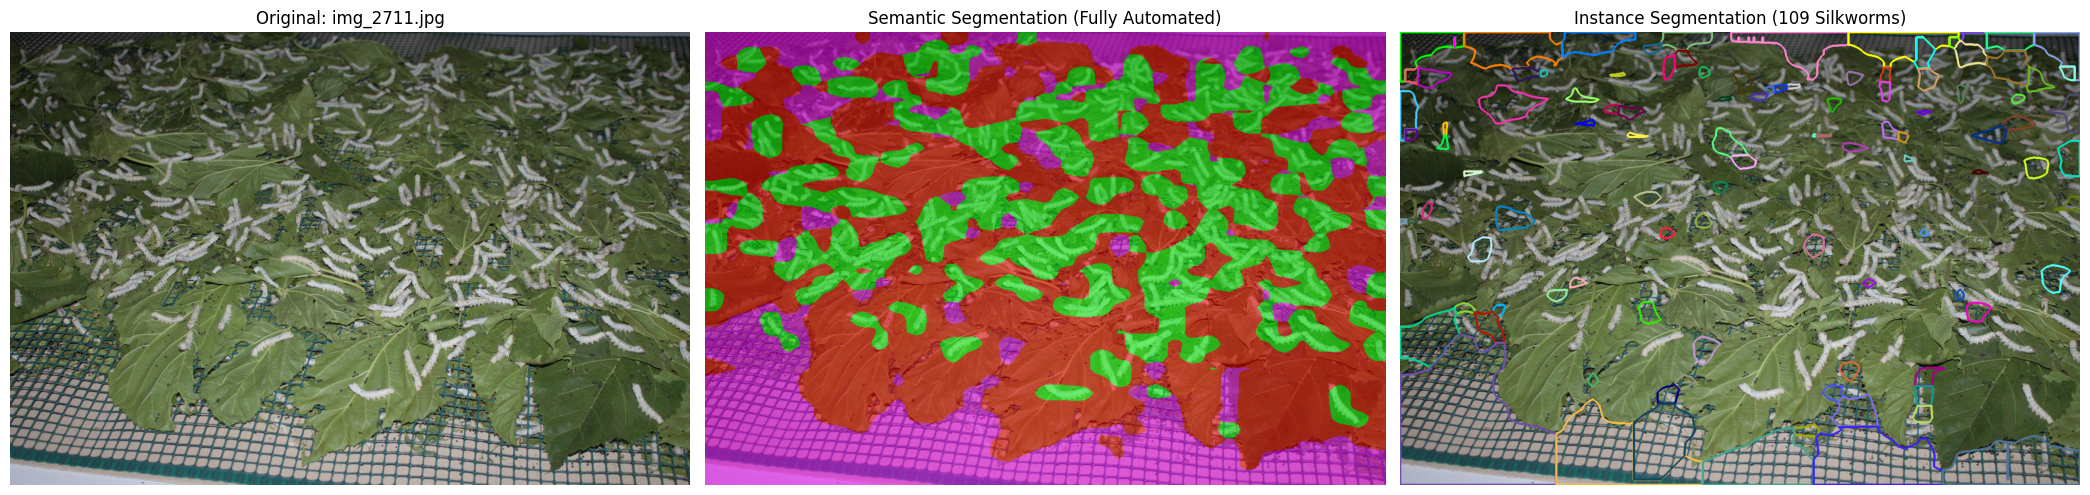


Processing image: silk_dataset\img_2849.jpg
Total silkworm instances detected: 31
Semantic categories automatically identified as: {0: 'silkworms', 1: 'leaves', 2: 'background'}


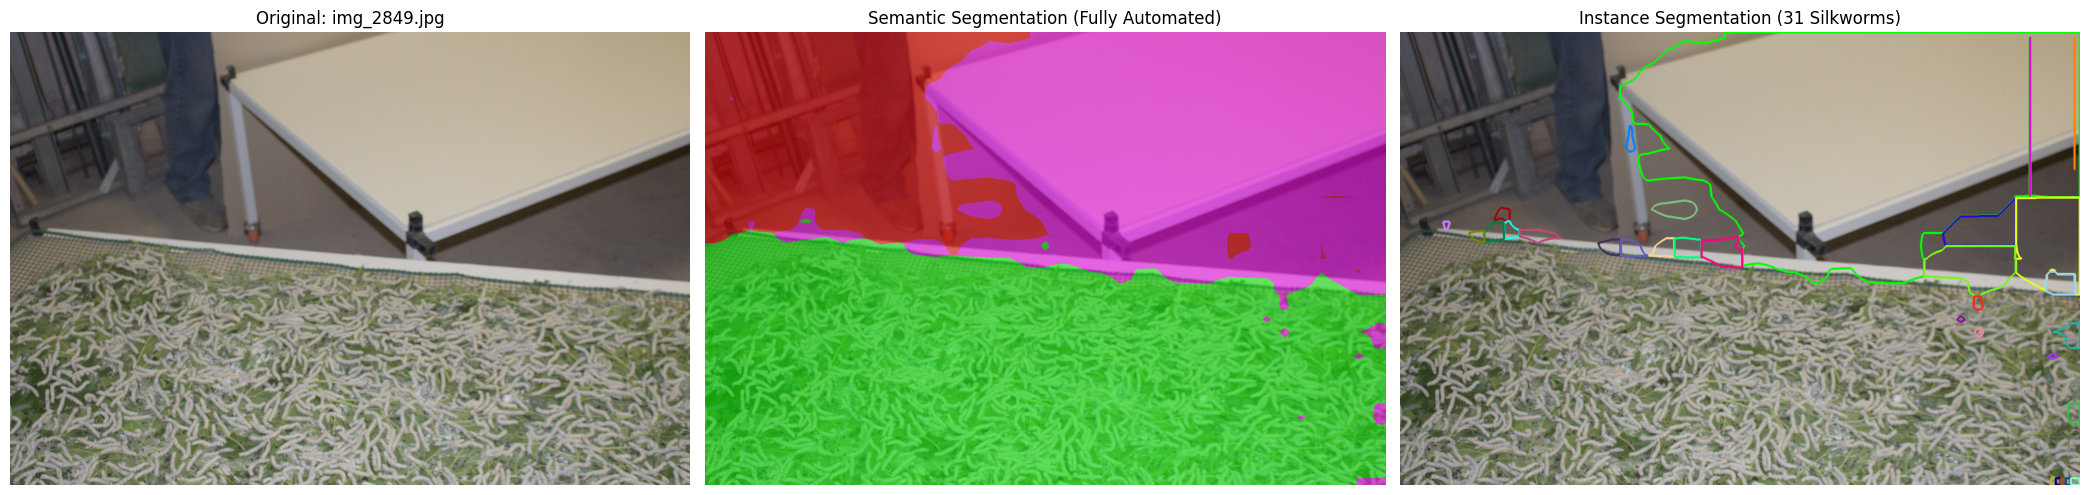


Processing image: silk_dataset\img_2868.jpg
Total silkworm instances detected: 53
Semantic categories automatically identified as: {1: 'silkworms', 2: 'leaves', 0: 'background'}


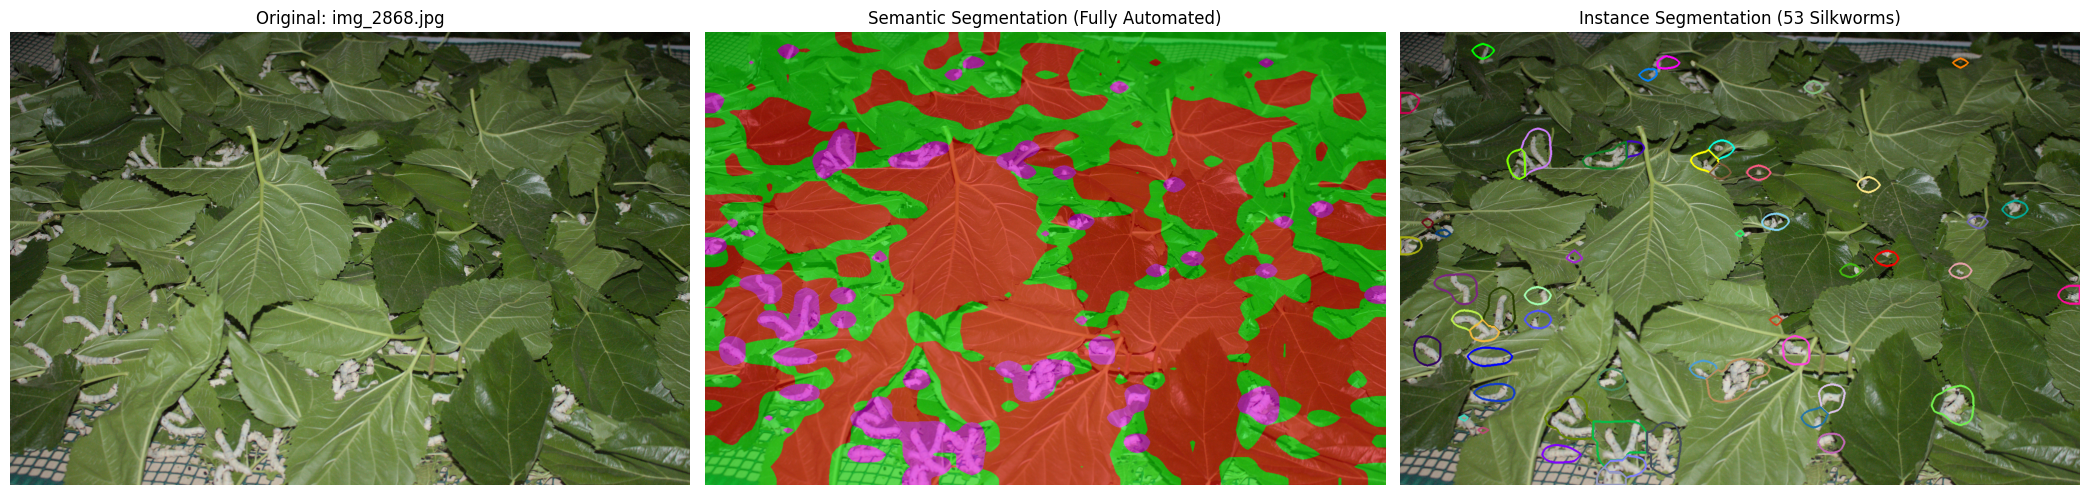


Processing image: silk_dataset\img_3009.jpg
Total silkworm instances detected: 187
Semantic categories automatically identified as: {0: 'silkworms', 1: 'leaves', 2: 'background'}


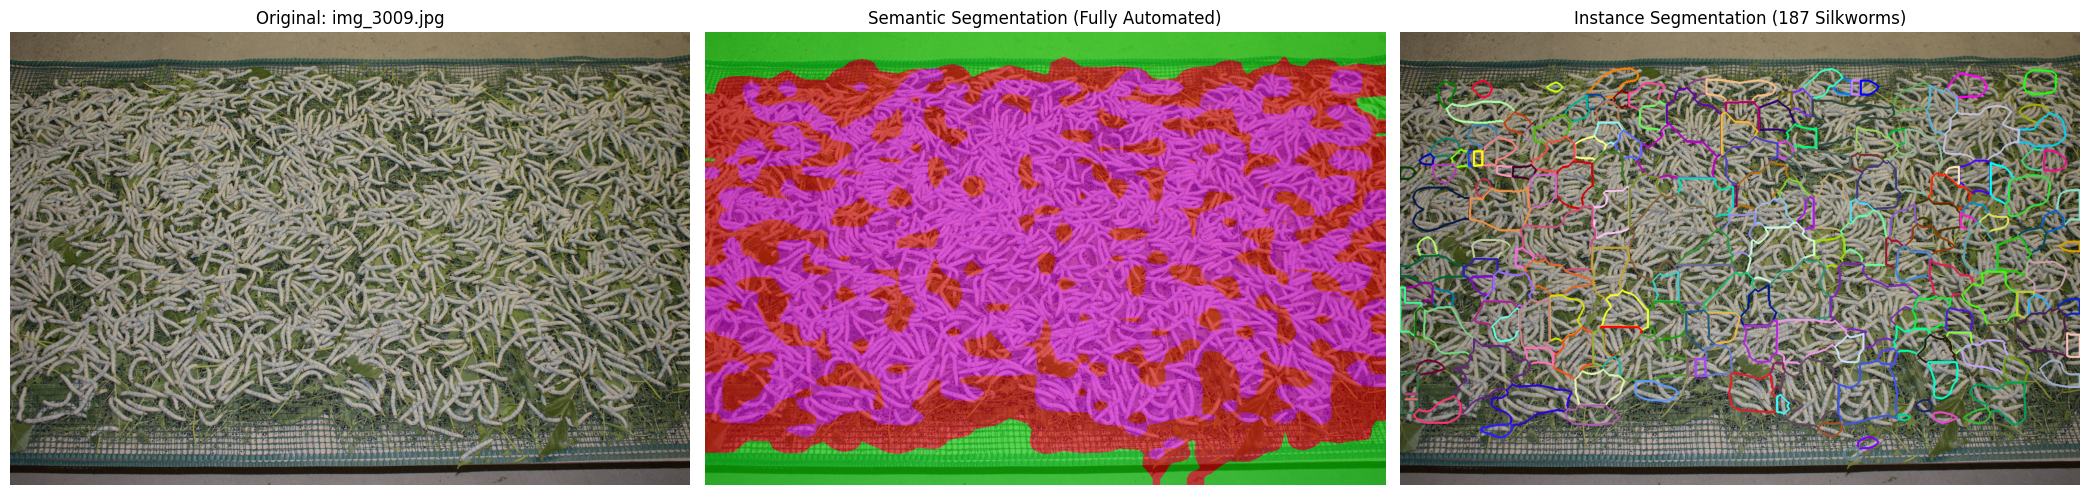


--- Evaluation Finished ---


In [7]:
# ===================================================================
# # 7. Evaluation
# This is the main execution block. It initializes the models and
# runs the full pipeline on the list of specified test images.
# ===================================================================
print("--- Starting Evaluation ---")

# --- Initialize Models ---
feature_extractor = DINOFeatureExtractor(device=DEVICE)
semantic_segmentor = SemanticSegmentation()
instance_segmentor = InstanceSegmentation()
main_pipeline = FinalPipeline(feature_extractor, semantic_segmentor, instance_segmentor)

# --- Run Pipeline on all Test Images ---
for filename in TEST_IMAGE_FILENAMES:
    image_path = os.path.join(DATASET_FOLDER, filename)

    if os.path.exists(image_path):
        print(f"\nProcessing image: {image_path}")
        
        # Run the full segmentation and counting process
        results = main_pipeline.run(image_path)
        
        # Print a summary of the results
        print(f"Total silkworm instances detected: {results['silkworm_count']}")
        print("Semantic categories automatically identified as:", results['label_to_name_map'])
        
        # Display the visual results
        plot_segmentation_visualization(image_path, results)
    else:
        print(f"\nError: The image '{filename}' was not found in '{DATASET_FOLDER}'.")
        print("Please ensure the file exists and is named correctly.")

print("\n--- Evaluation Finished ---")

